In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
from sklearn.semi_supervised import SelfTrainingClassifier

---

In [4]:
train_df = pd.read_csv('/content/preprocessed_train.csv')
test_df = pd.read_csv('/content/preprocessed_test.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8693 non-null   int64  
 2   Destination   8693 non-null   int64  
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int64  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   Spa           8693 non-null   float64
 8   VRDeck        8693 non-null   float64
 9   Transported   8693 non-null   float64
 10  GroupSize     8693 non-null   int64  
 11  Companion     8693 non-null   int64  
 12  SurnameCount  8693 non-null   int64  
 13  CabinDeck_A   8693 non-null   float64
 14  CabinDeck_B   8693 non-null   float64
 15  CabinDeck_C   8693 non-null   float64
 16  CabinDeck_D   8693 non-null   float64
 17  CabinDeck_E   8693 non-null   float64
 18  CabinDeck_F   8693 non-null 

In [6]:
X = train_df.drop(columns='Transported')
y = train_df['Transported']

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [8]:
trial_model = xgb.XGBClassifier()
trial_model.fit(X_train, y_train)
y_trial_pred = trial_model.predict(X_valid)
print(classification_report(y_valid, y_trial_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79      1424
         1.0       0.80      0.77      0.78      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869



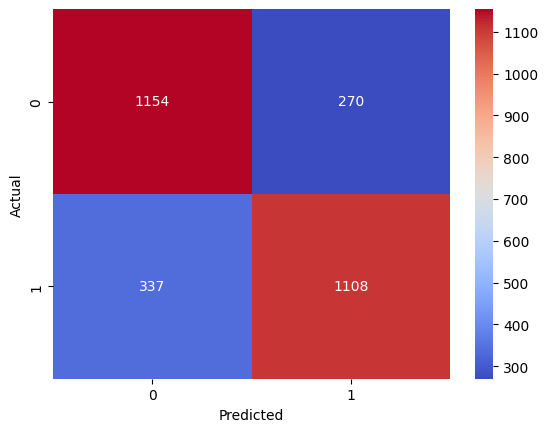

In [9]:
sns.heatmap(confusion_matrix(y_valid, y_trial_pred), annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature selection

In [10]:
selection_model = xgb.XGBClassifier()
selection_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
explainer = shap.Explainer(selection_model, X)
shap_values = explainer(X)

 98%|===================| 8559/8693 [00:44<00:00]       

In [12]:
shap_importance = np.round(np.abs(shap_values.values).mean(axis=0), 1) * 100
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': shap_importance
})
feature_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
1,CryoSleep,100.0
7,Spa,60.0
0,HomePlanet,50.0
5,RoomService,50.0
6,FoodCourt,50.0
8,VRDeck,50.0
3,Age,30.0
22,CabinSide_S,20.0
18,CabinDeck_G,20.0
14,CabinDeck_C,20.0


In [13]:
selected_features = feature_importance_df[feature_importance_df['Importance'] >= 10]['Feature'].tolist()
selected_features

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'RoomService',
 'FoodCourt',
 'Spa',
 'VRDeck',
 'GroupSize',
 'SurnameCount',
 'CabinDeck_B',
 'CabinDeck_C',
 'CabinDeck_E',
 'CabinDeck_F',
 'CabinDeck_G',
 'CabinSide_P',
 'CabinSide_S']

In [ ]:
X_selected = X[selected_features]
X_train_selected = X_train[selected_features]
X_valid_selected = X_valid[selected_features]

In [ ]:
trial_model = xgb.XGBClassifier()
trial_model.fit(X_train_selected, y_train)
y_trial_pred = trial_model.predict(X_valid_selected)
print(classification_report(y_valid, y_trial_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79      1424
         1.0       0.80      0.77      0.78      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869



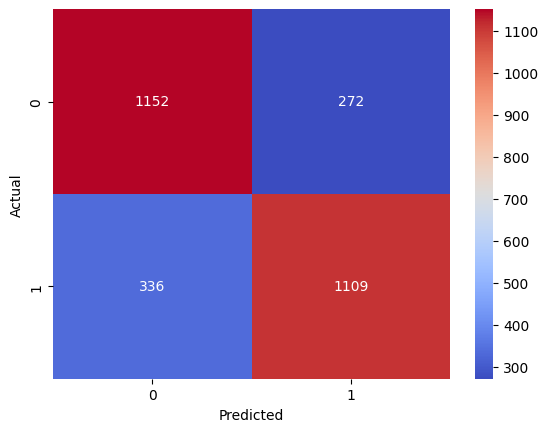

In [ ]:
sns.heatmap(confusion_matrix(y_valid, y_trial_pred), annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Even if the scores is almost equal, I'm going to use the feature selection for practice

In [ ]:
joblib.dump(selected_features, 'feature_selection.joblib')

['feature_selection.joblib']

# Training data augmentation (semi-supervised learning)

Checking the performance of predicting labels in general

In [ ]:
augmentation_model = xgb.XGBClassifier()
augmentation_model.fit(X_selected, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
test_df_selected = test_df[selected_features]

In [ ]:
probabilities = augmentation_model.predict_proba(test_df_selected)
y_pred = augmentation_model.predict(test_df_selected)

In [ ]:
results_table = pd.DataFrame(y_pred, columns=['Prediction'])
results_table['Probability'] = probabilities.max(axis=1)
results_table

,Prediction,Probability
0,1,0.743501
1,0,0.893105
2,1,0.996932
3,1,0.643937
4,1,0.602772
...,...,...
4272,1,0.713474
4273,0,0.660633
4274,1,0.963991
4275,0,0.837963


<Axes: ylabel='Frequency'>

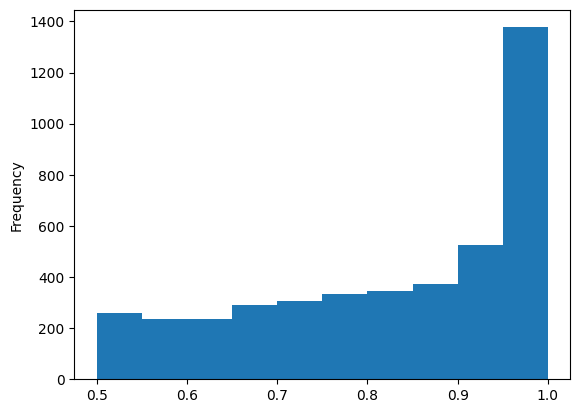

In [ ]:
results_table['Probability'].plot(kind='hist')

---

In [ ]:
X_train_augmentation = pd.concat([X_train_selected, test_df_selected], ignore_index=True)
y_train_augmentation = pd.concat([pd.Series(y_train), pd.Series([-1] * test_df.shape[0])], ignore_index=True)

In [ ]:
X_train_augmentation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10101 entries, 0 to 10100
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    10101 non-null  int64  
 1   CryoSleep     10101 non-null  int64  
 2   Destination   10101 non-null  int64  
 3   Age           10101 non-null  float64
 4   RoomService   10101 non-null  float64
 5   FoodCourt     10101 non-null  float64
 6   Spa           10101 non-null  float64
 7   VRDeck        10101 non-null  float64
 8   GroupSize     10101 non-null  int64  
 9   SurnameCount  10101 non-null  int64  
 10  CabinDeck_B   10101 non-null  float64
 11  CabinDeck_C   10101 non-null  float64
 12  CabinDeck_E   10101 non-null  float64
 13  CabinDeck_F   10101 non-null  float64
 14  CabinDeck_G   10101 non-null  float64
 15  CabinSide_P   10101 non-null  float64
 16  CabinSide_S   10101 non-null  float64
dtypes: float64(12), int64(5)
memory usage: 1.3 MB


In [ ]:
y_train_augmentation

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
10096,-1.0
10097,-1.0
10098,-1.0
10099,-1.0


In [ ]:
self_model = xgb.XGBClassifier()
self_training = SelfTrainingClassifier(self_model, threshold=0.90, max_iter=15, verbose=True)

Testing the accuracy score for threshold = {0.85, 0.90, 0.95} and max_iter = {1, 5, 10, 15}

In [ ]:
self_training.fit(X_train_augmentation, y_train_augmentation)

End of iteration 1, added 2012 new labels.
End of iteration 2, added 367 new labels.
End of iteration 3, added 170 new labels.
End of iteration 4, added 97 new labels.
End of iteration 5, added 68 new labels.
End of iteration 6, added 44 new labels.
End of iteration 7, added 52 new labels.
End of iteration 8, added 30 new labels.
End of iteration 9, added 34 new labels.
End of iteration 10, added 28 new labels.
End of iteration 11, added 21 new labels.
End of iteration 12, added 16 new labels.
End of iteration 13, added 19 new labels.
End of iteration 14, added 10 new labels.
End of iteration 15, added 12 new labels.


SelfTrainingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...),
                       max_iter=15, threshold=0.9, verbose=True)

In [ ]:
y_train_augmentation_self = self_training.transduction_
y_train_augmentation_self

array([ 0.,  0.,  0., ...,  1., -1., -1.])

In [ ]:
augmented_train = pd.concat([X_train_selected, test_df_selected], ignore_index=True)
augmented_train

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,Spa,VRDeck,GroupSize,SurnameCount,CabinDeck_B,CabinDeck_C,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinSide_P,CabinSide_S
0,2,0,1,19.000000,1241.25,878.0,781.0,0.000,1,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,3,0,1,25.000000,113.00,0.0,1182.5,0.000,1,7,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,0,2,62.000000,100.00,0.0,1182.5,0.000,2,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,3,38.000000,0.00,172.0,1182.5,34.000,1,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,3,1,1,21.000000,0.00,0.0,0.0,0.000,1,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10096,3,1,1,34.000000,0.00,0.0,0.0,1103.125,2,10,0.0,0.0,0.0,0.0,1.0,0.0,1.0
10097,3,0,1,42.000000,0.00,847.0,10.0,144.000,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10098,2,1,3,29.405903,0.00,0.0,0.0,0.000,1,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10099,1,0,2,34.336159,0.00,2680.0,0.0,1103.125,1,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
augmented_train['Transported'] = y_train_augmentation_self
indexes_not_predicted = augmented_train.query("Transported != -1").index
augmented_train = augmented_train.loc[indexes_not_predicted]
augmented_train.sample(10)

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,Spa,VRDeck,GroupSize,SurnameCount,CabinDeck_B,CabinDeck_C,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinSide_P,CabinSide_S,Transported
2713,3,0,3,9.0,0.0,0.000000,0.0,0.0,2,4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4826,3,0,3,0.0,0.0,0.000000,0.0,0.0,1,7,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
509,3,0,1,67.0,26.0,809.000000,39.0,26.0,1,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1527,3,1,3,0.0,0.0,0.000000,0.0,0.0,7,15,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3399,3,0,1,23.0,0.0,0.000000,0.0,965.0,1,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
5687,2,0,2,37.0,610.0,132.330911,148.0,14.0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4597,1,0,3,26.0,8.0,6138.000000,3.0,754.0,2,6,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
5667,1,0,3,41.0,0.0,320.000000,1182.5,51.0,5,5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
233,3,0,1,3.0,0.0,0.000000,0.0,0.0,2,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6467,2,0,1,42.0,26.0,0.000000,430.0,0.0,4,11,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_augmented, y_augmented = augmented_train.drop(columns='Transported'), augmented_train['Transported']

In [ ]:
model_augment = xgb.XGBClassifier()
model_augment.fit(X_augmented, y_augmented)
y_pred_augment = model_augment.predict(X_valid_selected)
print(classification_report(y_valid, y_pred_augment))

              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      1424
         1.0       0.81      0.76      0.78      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869



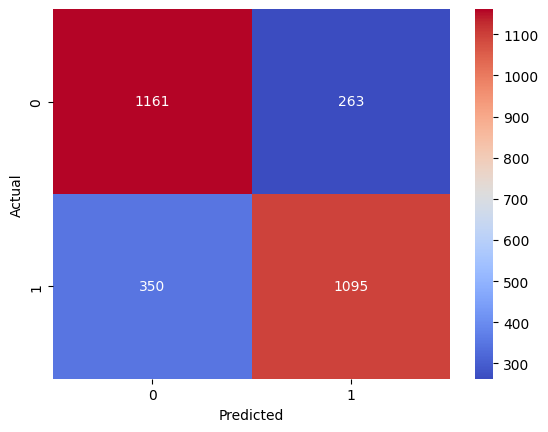

In [ ]:
sns.heatmap(confusion_matrix(y_valid, y_pred_augment), annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

original_df = 270 FP - 337 FN <br>

max_iter = 10 <br>
threshold 0.85 = 265 FP - 351 FN <br>
threshold 0.90 = 272 FP - 341 FN <br>
threshold 0.95 = 262 FP - 335 FN <br>

max_iter = 5 <br>
threshold 0.85 = 267 FP - 348 FN <br>
threshold 0.90 = 267 FP - 353 FN <br>
threshold 0.95 = 275 FP - 337 FN <br>

max_iter = 1 <br>
threshold 0.85 = 273 FP - 326 FN <br>
threshold 0.90 = 270 FP - 330 FN <br>
threshold 0.95 = 275 FP - 339 FN <br>
threshold 0.80 = 258 FP - 347 FN <br>
threshold 0.75 = 261 FP - 344 FN <br>

Best combination: max_iter=10 and threshold=0.95

---

In [ ]:
new_X_train = pd.concat([X_selected, test_df_selected], ignore_index=True)
new_y_train = pd.concat([pd.Series(y), pd.Series([-1] * test_df.shape[0])], ignore_index=True)

In [ ]:
new_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  int64  
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  int64  
 3   Age           12970 non-null  float64
 4   RoomService   12970 non-null  float64
 5   FoodCourt     12970 non-null  float64
 6   Spa           12970 non-null  float64
 7   VRDeck        12970 non-null  float64
 8   GroupSize     12970 non-null  int64  
 9   SurnameCount  12970 non-null  int64  
 10  CabinDeck_B   12970 non-null  float64
 11  CabinDeck_C   12970 non-null  float64
 12  CabinDeck_E   12970 non-null  float64
 13  CabinDeck_F   12970 non-null  float64
 14  CabinDeck_G   12970 non-null  float64
 15  CabinSide_P   12970 non-null  float64
 16  CabinSide_S   12970 non-null  float64
dtypes: float64(12), int64(5)
memory usage: 1.7 MB


In [ ]:
new_y_train

,0
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0
...,...
12965,-1.0
12966,-1.0
12967,-1.0
12968,-1.0


In [ ]:
self_model = xgb.XGBClassifier()
self_training = SelfTrainingClassifier(self_model, threshold=0.95, max_iter=10, verbose=True)

In [ ]:
self_training.fit(new_X_train, new_y_train)

End of iteration 1, added 1377 new labels.
End of iteration 2, added 265 new labels.
End of iteration 3, added 116 new labels.
End of iteration 4, added 92 new labels.
End of iteration 5, added 64 new labels.
End of iteration 6, added 57 new labels.
End of iteration 7, added 45 new labels.
End of iteration 8, added 43 new labels.
End of iteration 9, added 35 new labels.
End of iteration 10, added 37 new labels.


SelfTrainingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...),
                       threshold=0.95, verbose=True)

In [ ]:
new_train_df = pd.concat([X_selected, test_df_selected], ignore_index=True)
new_train_df

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,Spa,VRDeck,GroupSize,SurnameCount,CabinDeck_B,CabinDeck_C,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinSide_P,CabinSide_S
0,1,0,1,39.000000,0.0,0.0,0.0,0.000,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3,0,1,24.000000,109.0,9.0,1182.5,44.000,1,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0,1,58.000000,43.0,3576.0,1182.5,49.000,2,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,1,33.000000,0.0,1283.0,1182.5,193.000,2,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3,0,1,16.000000,303.0,70.0,565.0,2.000,1,9,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,3,1,1,34.000000,0.0,0.0,0.0,1103.125,2,10,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12966,3,0,1,42.000000,0.0,847.0,10.0,144.000,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12967,2,1,3,29.405903,0.0,0.0,0.0,0.000,1,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12968,1,0,2,34.336159,0.0,2680.0,0.0,1103.125,1,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
new_train_df['Transported'] = self_training.transduction_
indexes_not_predicted = new_train_df.query("Transported != -1").index
new_train_df = new_train_df.loc[indexes_not_predicted]
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10824 entries, 0 to 12967
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    10824 non-null  int64  
 1   CryoSleep     10824 non-null  int64  
 2   Destination   10824 non-null  int64  
 3   Age           10824 non-null  float64
 4   RoomService   10824 non-null  float64
 5   FoodCourt     10824 non-null  float64
 6   Spa           10824 non-null  float64
 7   VRDeck        10824 non-null  float64
 8   GroupSize     10824 non-null  int64  
 9   SurnameCount  10824 non-null  int64  
 10  CabinDeck_B   10824 non-null  float64
 11  CabinDeck_C   10824 non-null  float64
 12  CabinDeck_E   10824 non-null  float64
 13  CabinDeck_F   10824 non-null  float64
 14  CabinDeck_G   10824 non-null  float64
 15  CabinSide_P   10824 non-null  float64
 16  CabinSide_S   10824 non-null  float64
 17  Transported   10824 non-null  float64
dtypes: float64(13), int64(5)
memory

In [ ]:
new_train_df.to_csv('new_train.csv', index=False)